# Plant Seedlings Classification - Tensorflow Project

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import random
import glob
from IPython.display import Image as img
from PIL import Image
import cv2
#https://gist.github.com/eerwitt/518b0c9564e500b4b50f
#https://www.kaggle.com/gimunu/data-augmentation-with-keras-into-cnn
#https://www.kaggle.com/lextoumbourou/humpback-whale-id-data-and-aug-exploration
#https://www.youtube.com/watch?v=ViO56ASqeks

In [2]:
IMG_SIZE = (28, 28)

## Data

### - One Hot labels

In [3]:
dirs = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent',
       'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
values = np.array(dirs)
print(values,'\n')

#transformando em one hot
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
onehot_encoder = OneHotEncoder(sparse=False)

integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encodeded = np.array(onehot_encoder.fit_transform(integer_encoded)).astype(int)
print(onehot_encodeded)

['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat'
 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed' 'Shepherds Purse'
 'Small-flowered Cranesbill' 'Sugar beet'] 

[[1 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 1]]


### - Training Data

In [4]:
training_path = '../data/SeedlingData/train/'
training_data = []
__ = -1;
for img_class in dirs:
    __ += 1
    _=0;
    for filename in glob.glob(training_path+img_class+'/*.png'):
        im = cv2.imread(filename, 0)
        im = cv2.resize(im, IMG_SIZE)
        training_data.append([im, onehot_encodeded[__]])
#         if _==0:
#             display(img(filename, width=80, height=80))
#             print(filename)
#             print(onehot_encodeded[__])
#         _+= 1
random.shuffle(training_data)

### - Test Data

In [5]:
test_path = '../data/SeedlingData/test/'
test_data = []
for filename in glob.glob(test_path+'/*.png'):
    im = cv2.imread(filename)
    im = cv2.resize(im, IMG_SIZE)
    test_data.append(im)

### Building Model

In [6]:
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(init_random_dist)

In [7]:
def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

In [8]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides = [1,1,1,1], padding='SAME')

In [9]:
def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides = [1,2,2,1], padding='SAME')

In [10]:
def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W)+b)

In [11]:
def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

In [13]:
# placeholders
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 12])

In [14]:
#layers
x_image = tf.reshape(x, [-1, 28, 28, 1])

In [15]:
convo_1 = convolutional_layer(x_image, shape=[5,5,1,32])
convo_1_pooling = max_pool_2by2(convo_1)

In [16]:
convo_2 = convolutional_layer(convo_1_pooling, shape=[5,5,32,64])
convo_2_pooling = max_pool_2by2(convo_2)

In [17]:
convo_2_flat = tf.reshape(convo_2_pooling, [-1, 7*7*64])

In [18]:
full_layer_one = tf.nn.relu(normal_full_layer(convo_2_flat, 1024))

In [19]:
#dropout
hold_prob = tf.placeholder(tf.float32)
full_one_dropout = tf.nn.dropout(full_layer_one, keep_prob=hold_prob)

In [20]:
y_pred = normal_full_layer(full_one_dropout, 12)

In [21]:
#Loss
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_pred))

In [22]:
#Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train = optimizer.minimize(cross_entropy)

In [23]:
init = tf.global_variables_initializer()

In [24]:
steps = 5000

In [31]:
with tf.Session() as sess:
    sess.run(init)
    for i in range(steps):
        rand_ind = np.random.randint(len(training_data), size=10)
        feed = {x:training_data[rand_ind][0], y_:training_data[rand_ind][1]}
        sess.run(train, feed_dict = feed)
        
        if i%100 == 0:
            print('ON STEP: {}'.format(i))
            print('ACCURACY: ')
            matches = tf.equal(tf.argmax(y_, 1), tf.argmax(y_, 1))
            acc = tf.reduce_mean(tf.cast(matchs, tf.float32))
            print(sess.run(acc, feed_dict = feed))

TypeError: only integer scalar arrays can be converted to a scalar index

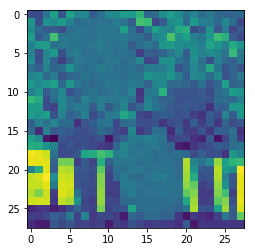

In [66]:
# plt.imshow(image_list[random.randrange(0, 1000)])
# print(image_list[random.randrange(0, 1000)])
plt.imshow(training_data[random.randrange(0,4000)][0])

In [121]:
print(label_list[random.randrange(0,4000)])

[0 0 0 0 0 0 0 0 0 1 0 0]
